In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm

from proteus.utils.plot import _preset_colours, get_colour, latexify


In [2]:
import utils.load_grid as lg

In [3]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### original data

In [6]:
title = "TRAPPIST-1 c"
outdir = os.path.join(os.environ.get("HOME"),"analysis/data/article_data/mnras_proteus_agni/plots/chem/")

ori_path = os.path.join(outdir,"ori/atm.nc")
ori_data = lg.readncdf(ori_path)

new_path = os.path.join(outdir,"new/atm.nc")
new_data = lg.readncdf(new_path)

### re-simulated data

### compare

In [7]:
print(new_data["x_gas"].shape)
print(len(new_data["gases"]))

(60, 48)
48


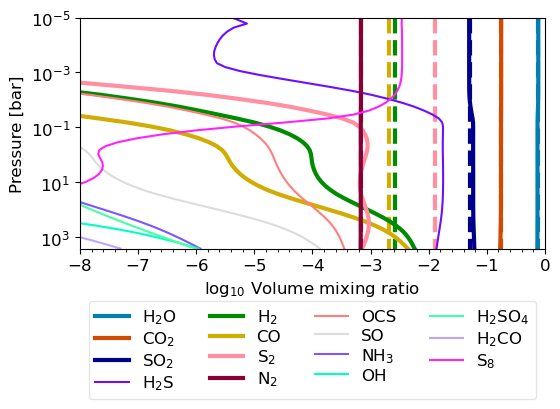

In [12]:
fig,ax = plt.subplots(1,1, figsize=(6,3))

xlim = [-8, 0]
lw=1.5
lw_factor=2

# which gases?
plt_gases = []
for i,g in enumerate(new_data["gases"]):
    x = new_data["x_gas"][:,i]

    if np.amax(x) < 10**xlim[0]:
        continue

    if ("Si" in g) or ("Mg" in g) or ("Fe" in g):
        continue

    if len(g) == 1:
        continue

    plt_gases.append(g)

# plot old mixing ratios
for i,g in enumerate(ori_data["gases"]):
    if g not in plt_gases:
        continue

    y = ori_data["p"]/1e5
    x = ori_data["x_gas"][:,i]


    x = np.log10(x)
    col = get_colour(g)

    if g in _preset_colours.keys():
        _lw = lw*lw_factor
    else:
        _lw = lw
    ax.plot(x,y, color=col, ls='dashed', lw=_lw)

# sort descending
x_ref = []
for i,g in enumerate(new_data["gases"]):
    x = new_data["x_gas"][:,i]
    x_ref.append(x[-1])
mask = np.argsort(x_ref)[::-1]


# plot new mixing ratios
for i in mask:
    g = new_data["gases"][i]
    if g not in plt_gases:
        continue

    y = new_data["p"]/1e5
    x = new_data["x_gas"][:,i]

    x = np.log10(x)
    col = get_colour(g)
    lbl = latexify(g)

    if g in _preset_colours.keys():
        _lw = lw*lw_factor
    else:
        _lw = lw
    ax.plot(x,y, color=col, lw=_lw, label=lbl)

    # idx = np.argmin(np.percentile(x,45) - x)
    # ax.text(x[idx],y[idx], lbl, color=col)


# decorate
ax.set_yscale("log")
ax.set_ylim(bottom=np.amax(new_data["pl"]/1e5), top=np.amin(new_data["pl"])/1e5)
ax.set_ylabel("Pressure [bar]")

ax.set_xlim(left=xlim[0], right=xlim[1])
ax.set_xlabel("log$_{10}$ Volume mixing ratio")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19), ncol=4, fancybox=True, framealpha=0.5, labelspacing=0.2)


# save
plt.show()
for fmt in ["png","pdf"]:
    fig.savefig("output/chem_compare.%s"%fmt,bbox_inches='tight', dpi=300)

In [11]:
# check temperature difference
print("temperature difference")
t_ori = ori_data["tmp"]
t_new = new_data["tmp"]
t_dif = np.abs(t_new - t_ori)
print(np.amax(t_dif))
print(np.argmax(t_dif))
print(np.amax(t_dif)/t_ori[np.argmax(t_dif)]*100)

# check mmw difference
print(" ")
print("mmw difference")
m_ori = ori_data["mmw"]
m_new = new_data["mmw"]
m_dif = np.abs(m_new - m_ori)
print(np.amax(m_dif))
print(np.argmax(m_dif))
print(np.amax(m_dif)/m_ori[np.argmax(m_dif)]*100)

print(" ")
print("OLR difference")
f_ori = ori_data["fl_U_LW"][0]
f_new = new_data["fl_U_LW"][0]
f_dif = abs(f_new - f_ori)
print(f_dif)
print(f_dif/f_ori*100)



temperature difference
38.75189764669494
45
4.358282291826166
 
mmw difference
0.0002803943557232007
10
1.1013872164805107
 
OLR difference
0.020768787490169416
0.001350130452834095
